In [1]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [24]:
def sum_on_samples(R, samples, n_classes):
    G = []
    for j in range(n_classes):
        class_sum = 0
        for i in samples:
            class_sum += R[(i, j)]
        G.append(class_sum)
    return G


def sum_on_classes(R, samples, n_classes):
    S = []
    for i in samples:
        sample_sum = 0
        for j in range(n_classes):
            sample_sum += R[(i, j)]
        S.append(sample_sum)
    return S


def get_constraint_for_classes(global_constraint, n_samples):
    n = np.ones(len(global_constraint))
    for j, const_num in enumerate(global_constraint):
        if const_num == -1:
            n[j] = 1.0
        else:
            n[j] = const_num / n_samples  # percentage for each constraint
    return n


In [25]:
def operation_research_func(samples, cost_matrix, global_constarint, subgroup_info, random_state =42):
    np.random.seed(random_state)
    R = {}
    objective_function = 0
    n_samples = samples.shape[0]
    predict_labels_proba = samples.drop('subgroup', axis=1)
    samples_idx = samples.index
    n_classes = predict_labels_proba.shape[1] 
    predict_hard = np.zeros(n_samples).astype(int)
    
    solver = pywraplp.Solver.CreateSolver('GLOP')

    if len(cost_matrix.shape)<=2:
        cost_dot_proba = np.dot(cost_matrix, predict_labels_proba.transpose())
    else:
        cost_dot_proba  = []
        for i in range(cost_matrix.shape[0]):
            cost_dot_proba.append(np.dot(cost_matrix[i], predict_labels_proba.loc[i]))
        cost_dot_proba = np.array(cost_dot_proba).transpose()


    # create variables 
    for i in range(n_samples):
        for j in range(n_classes):
            R[(i, j)] = solver.NumVar(0, solver.infinity(), 'R{}{}'.format(i, j))
            objective_function += R[(i, j)] * cost_dot_proba[j, i] 
    
    # Objective function
    solver.Minimize(objective_function)
    
    print("Number of variables =", solver.NumVariables())

    # Constraints
    
    #global constraint
    n = get_constraint_for_classes(global_constarint, n_samples) # constraint for each class
    G = sum_on_samples(R, samples_idx, n_classes) 
    for i in range(n_classes):
        solver.Add(G[i] <= np.ceil(n_samples * n[i])) 
    
    #single class
    S = sum_on_classes(R, samples_idx, n_classes) 
    for j in range(n_samples):
        solver.Add(S[j] >= 1)
        
    #local constraint
    for k, value in subgroup_info.items():
        samples_subgroup = samples[samples['subgroup'] == k]
        n = get_constraint_for_classes(value, samples_subgroup.shape[0])
        L = sum_on_samples(R, samples_subgroup.index, n_classes)
        for i in range(n_classes):
            solver.Add(L[i] <= np.ceil(samples_subgroup.shape[0] * n[i])) 

    print('Number of constraints =', solver.NumConstraints())

    status = solver.Solve()

    for i in range(n_samples):
        for j in range(n_classes):
            #print(' R[({}, {})] ='.format(i, j),  R[(i, j)].solution_value())
            if R[(i, j)].solution_value() == 1:
                predict_hard[i] = j # the sample get the class
            if R[(i, j)].solution_value() not in [0,1]:
                print('The solution is not 0 or 1')

        
    if status == pywraplp.Solver.OPTIMAL:
        print("Solution:")
        print(f"Objective value = {solver.Objective().Value():0.1f}")

    else:
        print("The problem does not have an optimal solution.")

    print("\nAdvanced usage:")
    print(f"Problem solved in {solver.wall_time():d} milliseconds")
    print(f"Problem solved in {solver.iterations():d} iterations")
    
    return solver.Objective().Value(), predict_hard

In [26]:
def allocation_heuristic(samples, cost_matrix,  global_constraint, local_constraint, random_state=42):
    # for binary case only
    np.random.seed(random_state)
    n_samples = samples.shape[0]
    predict_labels_proba = samples.drop('subgroup', axis=1)
    predict_hard = np.zeros(n_samples).astype(int)
    
    if len(cost_matrix.shape)<=2:
        cost_dot_proba = np.dot(cost_matrix, predict_labels_proba.transpose()).transpose()
    else:
        cost_dot_proba  = []
        for i in range(cost_matrix.shape[0]):
            cost_dot_proba.append(np.dot(cost_matrix[i], predict_labels_proba.loc[i]))
        cost_dot_proba = np.array(cost_dot_proba)
        

    sort_proba = pd.DataFrame(cost_dot_proba).sort_values([0], axis=0, ascending=False)
    n_local ={}
    n_global = 0
    for s in sort_proba.index:
        if n_global < global_constraint[1]:
            temp_subgroup = samples.loc[s, 'subgroup']
            n_local[temp_subgroup] = n_local.get(temp_subgroup, 0) 
            if n_local[temp_subgroup] < local_constraint[temp_subgroup][1]:
                if sort_proba.loc[s,0] > sort_proba.loc[s,1]:
                    n_local[temp_subgroup] = n_local.get(temp_subgroup, 0)+1
                    n_global +=1
                    predict_hard[s] = 1
    
    objective_value = 0
    for i, predict in enumerate(predict_hard):
        objective_value += pd.DataFrame(cost_dot_proba).loc[i,predict]
        
    return objective_value, predict_hard, cost_dot_proba

In [5]:
# #small example
# #predict_labels_proba = np.array([[0.9,0.1], [0.7,0.3], [0.3,0.7], [0.2, 0.8]])#, [0.2 ,0.8], [0.3, 0.7]])
# predict_labels_proba = pd.DataFrame([[0.9,0.1], [0.7,0.3], [0.3,0.7], [0.2, 0.8]])
# samples = predict_labels_proba
# sub1 = '867c4a38-0d75-46ff-a4c2-f44cb63be2c9'
# sub2 = '280a19b6-a767-4e7f-b6b4-e422d6876897'
# samples['subgroup'] = [sub1, sub2, sub1, sub2]
# #cost_matrix = np.array([[[0,10],[1,1]], [[0,10],[1,1]], [[0,10],[2,1]], [[0,0],[1,1]]])
# cost_matrix = np.array([[0,10],[1,1]])
# # const_num = 1
# # constrained_classes = [1]
# global_constraint = [-1, 3]
# #subsets = {0: {'samples': [0, 2], 'constrained_classes': [1], 'const_num': 2} , 1: {'samples': [1, 3], 'constrained_classes': [1], 'const_num': 2}}
# #subgroup_info = {0: { 'constrained_classes': [1], 'const_num': 2} , 1: {'constrained_classes': [1], 'const_num': 2}}
# subgroup_info = {sub1: [-1, 2] , sub2: [-1, 2]}

# Examine integer results for multi-class

In [27]:
num_samples = 10000
num_classes = 5
probabilities = np.random.dirichlet(np.ones(num_classes), size=num_samples)
predict_labels_proba = pd.DataFrame(probabilities, columns=[i for i in range(num_classes)])

subgroups = np.random.randint(1, 4, size=num_samples)
samples = predict_labels_proba
samples['subgroup'] = subgroups

samples_info = pd.DataFrame(samples['subgroup'])
samples_info['predict_hard_max'] = samples[[0, 1,]].idxmax(axis="columns").astype(int)
samples_info['count'] = 1
subgroup_info = samples_info.groupby(['subgroup', 'predict_hard_max']).sum('count')
subgroup_info['count']

subgroup  predict_hard_max
1         0                   1684
          1                   1686
2         0                   1685
          1                   1667
3         0                   1690
          1                   1588
Name: count, dtype: int64

In [28]:
sub1 = 1
sub2 = 2
sub3 = 3
# subgroup_constraint = {sub1: [-1, 30] , sub2: [-1, 130], sub3: [-1, 50]}
# cost_matrix = np.array([[0,1],[1, 0]])
# cost_matrix = np.array([cost_matrix for i in range(samples.shape[0])])
# global_constraint = [-1, 200]
# for 5 classes
subgroup_constraint = {sub1: [-1, 300, 400, 300, 200] , sub2: [-1, 500, 200, 300, 300], sub3: [-1, 100, 300, 500, 600]}
cost_matrix = np.array([[0,1,1, 1, 1],[1, 0, 1, 1, 1], [1, 1, 0, 1, 1], [1, 1, 1, 0, 1], [1, 1, 1, 1, 0]])
global_constraint = [-1, 700, 200, 1000, 500]

In [29]:
cost_matrix = np.array([cost_matrix for i in range(samples.shape[0])])

In [30]:
objective_function_value, predict_hard= operation_research_func(samples, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

Number of variables = 50000
Number of constraints = 10020
Solution:
Objective value = 6776.0

Advanced usage:
Problem solved in 8748 milliseconds
Problem solved in 14604 iterations


# Apply allocation heuristic 
- Sort by cost
- go over samples and check if there is a place consider the constraints

In [31]:
num_samples = 10000
num_classes = 2
probabilities = np.random.dirichlet(np.ones(num_classes), size=num_samples)
predict_labels_proba = pd.DataFrame(probabilities, columns=[i for i in range(num_classes)])

subgroups = np.random.randint(1, 4, size=num_samples)
samples = predict_labels_proba
samples['subgroup'] = subgroups

samples_info = pd.DataFrame(samples['subgroup'])
samples_info['predict_hard_max'] = samples[[0, 1,]].idxmax(axis="columns").astype(int)
samples_info['count'] = 1
subgroup_info = samples_info.groupby(['subgroup', 'predict_hard_max']).sum('count')
subgroup_info['count']

subgroup  predict_hard_max
1         0                   1735
          1                   1668
2         0                   1600
          1                   1623
3         0                   1642
          1                   1732
Name: count, dtype: int64

In [32]:
sub1 = 1
sub2 = 2
sub3 = 3
subgroup_constraint = {sub1: [-1, 500] , sub2: [-1, 500], sub3: [-1, 500]}
cost_matrix = np.array([[0,1],[1, 0]])
cost_matrix = np.array([cost_matrix for i in range(samples.shape[0])])
global_constraint = [-1, 100]


In [33]:
objective_value_heuristic, predict_hard_heuristic, _ = allocation_heuristic(samples, cost_matrix,  global_constraint, subgroup_constraint, random_state=42)

In [34]:
objective_value_heuristic

4908.655111134541

In [35]:
objective_function_value, predict_hard_or= operation_research_func(samples, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

Number of variables = 20000
Number of constraints = 10008
Solution:
Objective value = 4908.7

Advanced usage:
Problem solved in 3073 milliseconds
Problem solved in 10211 iterations


In [36]:
sum(predict_hard_or)

100

In [37]:
sum(predict_hard_heuristic)

100

In [38]:
predict_hard_or[predict_hard_or != predict_hard_heuristic]

array([], dtype=int32)

# Intuit dataset

In [39]:
df = pd.read_csv('data/feature_dataset_5000.csv')#reset_index()
test = df[df['prediction_date'] == '2023-07-31'].reset_index()
y_test = test['target']

In [40]:
samples_all = pd.read_csv('data/predict_proba.csv', index_col=False)
samples_all = samples_all.rename(columns={'provider_id': 'subgroup', '0': 0, '1': 1})
samples_all

,0,1,subgroup
0,0.531627,0.468373,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
1,0.108769,0.891231,280a19b6-a767-4e7f-b6b4-e422d6876897
2,0.365181,0.634819,89e6e230-1333-448b-9800-dc2d09a85e99
3,0.984345,0.015655,63260486-7618-4660-9445-7e4885e99042
4,0.782031,0.217969,50761787-31da-4b17-8048-c6063b614b80
...,...,...,...
4995,0.885391,0.114609,d3c35a47-5967-4bef-a39b-feafed32261c
4996,0.531627,0.468373,451e185d-5ad1-469f-8c33-164884140ffc
4997,0.108769,0.891231,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
4998,0.108769,0.891231,75f8d952-be81-4e22-951e-41b291d211f2


The constraints (global and local) are defined as a list with a constraint for each class (ordered). The constraint is the total number of samples for each class and -1 is for classes that don't have constraints. 

In [41]:
constraint_precent = 0.2
subgroup_constraint = {}
for provider, count in samples_all['subgroup'].value_counts().items():
    subgroup_constraint[provider] = [-1, np.ceil(constraint_precent*count)]
subgroup_constraint

{'867c4a38-0d75-46ff-a4c2-f44cb63be2c9': [-1, 155.0],
 'a12f6956-9aca-4550-8caa-2e2f9532674c': [-1, 63.0],
 '02531004-4599-4177-9d7d-00bc85a200c6': [-1, 50.0],
 '856f211d-c66e-4db7-b910-7419900a70e1': [-1, 41.0],
 '75f8d952-be81-4e22-951e-41b291d211f2': [-1, 37.0],
 '451e185d-5ad1-469f-8c33-164884140ffc': [-1, 22.0],
 'c8fa65fe-4bf6-4846-aaaa-62f8937e31bf': [-1, 21.0],
 '22f309a8-1746-49a7-bf6c-678729834573': [-1, 19.0],
 'd712a1f3-812a-4f41-a567-07b97ce32fa1': [-1, 15.0],
 'a0dc02cc-c56b-4931-ad79-8ed0d3bd2ffc': [-1, 15.0],
 '444b0293-8056-47e0-a3c8-cd7bca4997d3': [-1, 14.0],
 'a68c8f2a-f1a7-4c64-9dc4-d641c9371725': [-1, 14.0],
 '172d3f92-3da0-4ad9-b8e8-12d95102b35f': [-1, 12.0],
 'b954c933-d771-4dc0-8f4f-89db56cf7266': [-1, 11.0],
 '318dfa35-b3d4-48ac-83b0-a4428d01444c': [-1, 11.0],
 '555339a4-dbff-43f2-9c92-b0e03b1c6312': [-1, 10.0],
 '3f33a0b8-d4da-445a-baa3-678dfb0d8763': [-1, 9.0],
 '148d76c1-3e78-4581-b909-e4abd3496e12': [-1, 9.0],
 'dc4abe91-b03f-4dd2-9987-102db5767235': [-1, 7

In [42]:
user_1_cost_matrix = np.array([[0,10],[1,1]])
user_2_cost_matrix = np.array([[0,20],[1,1]])
user_3_cost_matrix = np.array([[0,30],[1,1]])

In [43]:
user_1_cost_matrix

array([[ 0, 10],
       [ 1,  1]])

In [44]:
np.random.seed(33)
#users_split = np.random.randint(3, size=samples_all.shape[0])
users_split = np.random.choice(np.arange(3), p=[0.1, 0.2, 0.7], size=samples_all.shape[0])

In [45]:
cost_matrix = []
for i in users_split:
    if i == 0:
        cost_matrix.append(user_1_cost_matrix)
    elif i == 1:
        cost_matrix.append(user_2_cost_matrix)
    else:
        cost_matrix.append(user_3_cost_matrix)
cost_matrix = np.array(cost_matrix)
cost_matrix.shape

(5000, 2, 2)

In [46]:
#cost_matrix = np.array([[0,1],[1,0]])
global_constraint = [-1, 2000]

In [47]:
# Without global constraint
objective_function_value, predict_hard_or = operation_research_func(samples_all, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

Number of variables = 10000
Number of constraints = 6782
Solution:
Objective value = 29573.6

Advanced usage:
Problem solved in 2653 milliseconds
Problem solved in 7005 iterations


In [48]:
objective_value_heuristic, predict_hard_heuristic, cost_dot_proba = allocation_heuristic(samples_all, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

In [49]:
objective_value_heuristic

29573.591885276044

In [50]:
sum(predict_hard_heuristic)

1416

The different allocation of the two methods, check if for each subgroup the probabilities are the same

In [51]:
diff_samples = samples_all[predict_hard_heuristic != predict_hard_or]
diff_samples

,0,1,subgroup
8,0.782031,0.217969,9b9f5ceb-dea2-49db-8476-4530c1b0c92d
11,0.531627,0.468373,f10c1b75-2c77-499f-953a-d98eb5302f3d
16,0.306757,0.693243,a12f6956-9aca-4550-8caa-2e2f9532674c
30,0.782031,0.217969,9b9f5ceb-dea2-49db-8476-4530c1b0c92d
58,0.782031,0.217969,324ebb81-07ca-4fa2-9235-6f023e806cdd
...,...,...,...
4873,0.782031,0.217969,9b9f5ceb-dea2-49db-8476-4530c1b0c92d
4890,0.885391,0.114609,cccbcaeb-5de1-4f8b-899d-f4fd8bc70176
4931,0.365181,0.634819,22f309a8-1746-49a7-bf6c-678729834573
4974,0.885391,0.114609,d09f5a4f-89bd-4262-89a1-70703fcd1d94


In [52]:
# to check if for each subgroup in the different allocation have the same probabilities
for s in diff_samples['subgroup'].unique():
    if diff_samples[diff_samples['subgroup'] == s][1].value_counts().shape[0] >1:   
        print(s, '\n')
        print(diff_samples[diff_samples['subgroup'] == s][1].value_counts().shape[0], '\n')

In [53]:
samples_all[samples_all['subgroup'] == s][1].value_counts().shape[0]

2

In [54]:
samples_all['predict_hard_max'] = samples_all[[0, 1]].idxmax(axis="columns").astype(int)

In [576]:
confusion_matrix(y_test, samples_all['predict_hard_max'])

array([[2410,  976],
       [ 326, 1288]], dtype=int64)

In [577]:
confusion_matrix(y_test, predict_hard_heuristic)

array([[3003,  383],
       [ 997,  617]], dtype=int64)

In [578]:
confusion_matrix(y_test, predict_hard_or)

array([[2999,  387],
       [1001,  613]], dtype=int64)

In [184]:
# Without local constraint
objective_function_value, predict_hard= operation_research_func(samples_all, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

Number of variables = 10000
Number of constraints = 5002
Solution:
Objective value = 40382.3

Advanced usage:
Problem solved in 2423 milliseconds
Problem solved in 5880 iterations


In [185]:
sum(predict_hard)

500

In [201]:
# With all constraint
objective_function_value, predict_hard= operation_research_func(samples_all, cost_matrix, global_constraint, subgroup_constraint, random_state =42)

Number of variables = 10000
Number of constraints = 6782
Solution:
Objective value = 29573.6

Advanced usage:
Problem solved in 3496 milliseconds
Problem solved in 7008 iterations


In [202]:
sum(predict_hard)

1416

In [205]:
samples_all['y_true'] = y_test

In [206]:
y_pred_const = np.array(samples_all['predict_hard_constraint'])


In [207]:
y_pred_clf = np.array(samples_all['predict_hard_max'])


In [208]:
confusion_matrix(y_pred_clf, y_pred_const)

array([[2320,  416],
       [1264, 1000]], dtype=int64)

In [209]:
confusion_matrix(y_test, y_pred_const)

array([[2648,  738],
       [ 936,  678]], dtype=int64)

In [210]:
confusion_matrix(y_test, y_pred_clf)

array([[2410,  976],
       [ 326, 1288]], dtype=int64)

In [211]:
subgroup_info = samples_all.groupby(['subgroup']).sum()[['predict_hard_constraint', 'predict_hard_max', 'y_true']]
subgroup_info['n_sample'] = samples_all.groupby(['subgroup']).count()[0]
subgroup_info['constraint'] = np.ceil(samples_all.groupby(['subgroup']).count()[0]*constraint_precent)

In [212]:
subgroup_info

,predict_hard_constraint,predict_hard_max,y_true,n_sample,constraint
subgroup,,,,,
00c7cc34-c4a8-432c-9a1d-53e54b3da2a9,2,0,1.0,6,2.0
00ff5627-038f-4a69-9ab2-3bbebb927042,1,1,0.0,1,1.0
0156d05a-906b-43fb-bef9-600f8d49c740,0,0,0.0,1,1.0
020111e3-2aa1-43c6-b789-4f9e4a395546,1,1,1.0,1,1.0
02519b96-f37e-4db5-8593-40a913fc554f,0,0,0.0,1,1.0
...,...,...,...,...,...
fe91abcc-a2c4-4b78-b588-b6cb6aa861a7,0,0,0.0,1,1.0
fec69360-bc66-4e53-9194-4f771d3a929f,1,1,0.0,1,1.0
fef4407e-10a3-4898-8b4f-7e1b577ac4b3,1,0,0.0,1,1.0


In [213]:
sliced_df = samples_all[samples_all['subgroup'] =='02531004-4599-4177-9d7d-00bc85a200c6']

In [214]:
confusion_matrix(sliced_df['y_true'], sliced_df['predict_hard_constraint'])

array([[128,  14],
       [ 71,  36]], dtype=int64)

In [215]:
confusion_matrix(sliced_df['y_true'], sliced_df['predict_hard_max'])

array([[60, 82],
       [14, 93]], dtype=int64)

In [93]:
subgroup_info['y_true'].sum()

1614.0

Text(0, 0.5, 'sum of positive under the constraint')

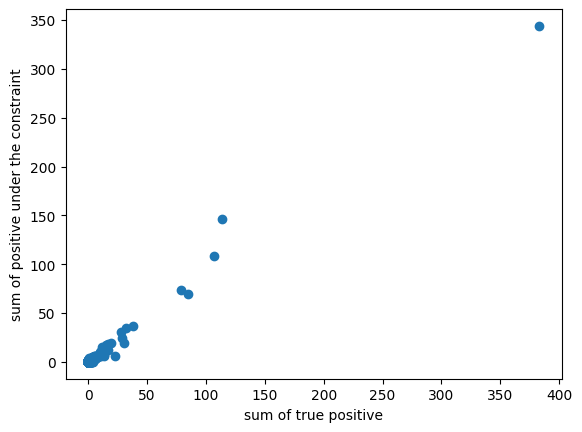

In [94]:
plt.scatter(subgroup_info['y_true'], subgroup_info['predict_hard_constraint'])
plt.xlabel('sum of true positive')
plt.ylabel('sum of positive under the constraint')
